单独使用show_result函数来查看训练好的模型的生成结果

In [2]:
import torch
import matplotlib.pyplot as plt
import itertools
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)    # 3个输出通道

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x


加载训练好的模型参数

In [3]:
# 实例化模型并加载权重
G = generator(128).cuda()  # 确保模型架构与训练时一致
G.load_state_dict(torch.load('MNIST_DCGAN_results/generator_param.pkl'))
G.eval()


generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

show_result函数用于生成和显示图像。

In [7]:

fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()  # fixed noise

def show_result(num_epoch, show=True, save=False, path='result.png', isFix=False):
    with torch.no_grad():
        z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1).cuda()

        if isFix:
            test_images = G(fixed_z_)
        else:
            test_images = G(z_)

        # 将图像数据从[-1, 1]归一化到[0, 1]
        test_images = (test_images + 1) / 2  

        size_figure_grid = 5
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)

        for k in range(5*5):
            i = k // 5
            j = k % 5
            ax[i, j].cla()
            ax[i, j].imshow(test_images[k].cpu().data.numpy().transpose(1, 2, 0))

        label = 'Epoch {0}'.format(num_epoch)
        fig.text(0.5, 0.04, label, ha='center')

        if save:
            plt.savefig(path)
        
        if show:
            plt.show()
        else:
            plt.close()


生成并查看结果

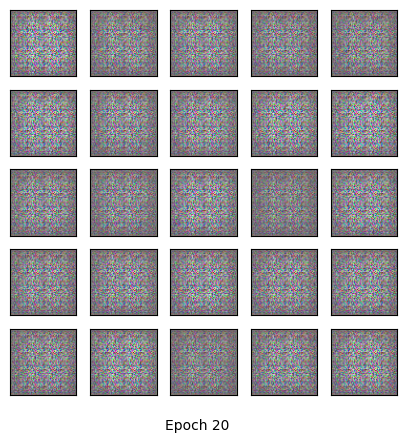

In [8]:
show_result(num_epoch=20, isFix=True)  # 假设你想查看第20个epoch的固定噪声结果
 